In [1]:
import sys
from pathlib import Path
sys.path.append('../../../')
from tqdm import tqdm_notebook as tqdm
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from data.roi_tile_exporter import ROITileExporter
from annotation.mask_converter import MaskConverter

In [2]:
data_dir = Path('/mnt/rescomp/projects/prostate-gland-phenotyping/WSI')
roi_dir_name = 'tumour_area_annotations'
exporter = ROITileExporter(data_dir, 'EU_37106_15_2K_HandE+-+2017-11-28+11.43.55', 1024, 0.2, roi_dir_name=roi_dir_name)

In [3]:
def export_tiles_debug(exp, area_layer, save_dir, select_coords = (), hier_rule=lambda x: x):
    save_dir = (Path(save_dir)/area_layer).expanduser()
    slide_dir = save_dir/exp.slide_id
    save_dir.mkdir(exist_ok=True), slide_dir.mkdir(exist_ok=True)
    try:
        areas_to_tile = exp.contour_lib[area_layer] if exp.roi_dir is None else exp.roi_contour_lib[area_layer]
    except KeyError:
        raise KeyError(f"Invalid exporting layer '{area_layer}': no such layer in annotation for {exp.slide_id}")
    contours, labels, bounding_rects = [], [], []
    for layer_name, layer_contours in exp.contour_lib.items():
        if layer_name == area_layer:
            continue  # get all contours except those delimiting the export area
        contours.extend(layer_contours)
        bounding_rects.extend(exp.bounding_boxes[layer_name])
        labels.extend([layer_name] * len(layer_contours))
    exp.slide.filter_locations(areas_to_tile)
    print("Extracting tiles and masks ...")
    num_saved_images = 0
    value_hier = sorted(exp.label_values.values(), key=hier_rule)
    converter = MaskConverter(value_hier=value_hier)
    x_tile_size = exp.tile_size*round(exp.mpp/exp.slide.mpp_x)
    y_tile_size = exp.tile_size*round(exp.mpp/exp.slide.mpp_y)
    for x, y in exp.slide.tissue_locations:
        if select_coords and (x, y) not in select_coords:
            continue
        tile_contours, tile_labels = exp.get_tile_contours(contours, bounding_rects, labels,
                                                            (x, y, x_tile_size, y_tile_size))
        if not tile_contours:
            continue
        mask = exp.stitch_segmentation_map(tile_contours, tile_labels, (x, y))
        mask = cv2.dilate(mask, np.ones((3, 3)))  # pre-dilate to remove jagged boundary from low-res contour extraction
        value_binary_masks = []
        for value in value_hier:
            value_binary_mask = converter.threshold_by_value(value, mask)
            value_binary_mask = (gaussian(value_binary_mask, sigma=exp.sigma_smooth) > 0.5).astype(np.uint8)  # smoothen jagged edges
            # value_binary_mask = converter.remove_ambiguity(
            #     value_binary_mask,
            #     small_object_size=0,  # no need to remove small objects from annotation
            #     final_closing_size=0,  # no need for large closing of annotation images
            #     final_dilation_size=3
            # )
            value_binary_masks.append(value_binary_mask)
        mask = np.zeros_like(mask)
        for value_binary_mask, value in zip(value_binary_masks, value_hier):
            mask[value_binary_mask > 0] = value
        mask = np.array(mask, dtype=np.uint8)
        tile = exp.slide.read_region((x, y))
        tile = np.array(tile, dtype=np.uint8)
        # resize mask according to mpp difference
        mask = cv2.resize(mask, tile.shape[:2], interpolation=cv2.INTER_NEAREST)
        assert tile.shape[:2] == mask.shape, f"Tile and mask shapes don't match: {tile.shape[:2]} != {mask.shape}"
        yield tile, mask, (x, y)

In [4]:
gen = export_tiles_debug(exporter, 'Tumour area', '~/Documents/Temp')

Extracting tiles and masks ...


../../../data/__init__.py:149: UserWarning: Returning empty mask after drawing ...
  warnings.warn("Returning empty mask after drawing ...")


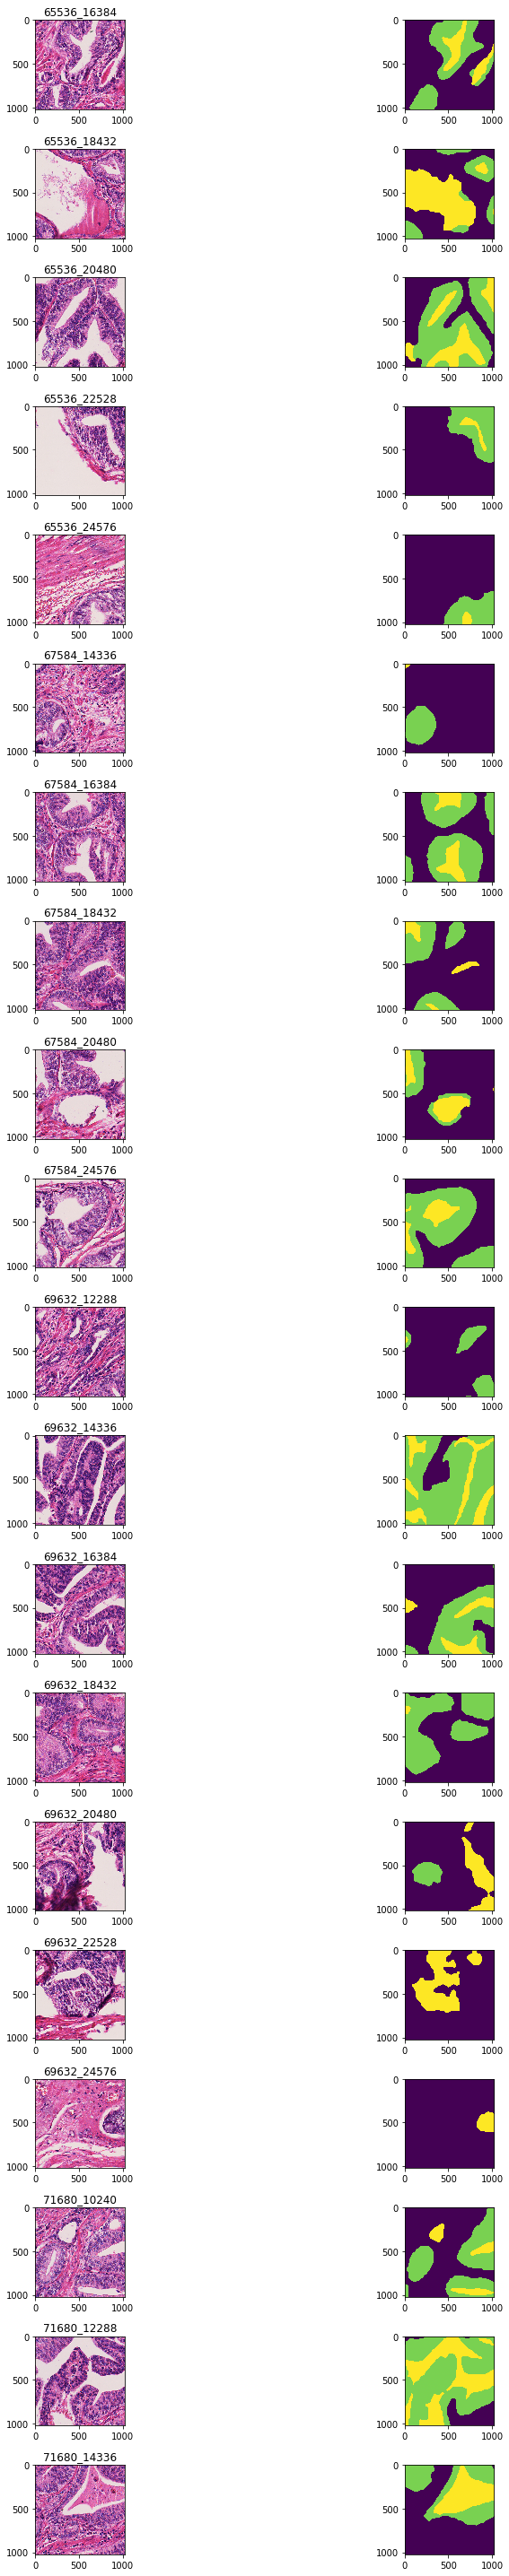

In [5]:
num = 20
masks, tiles = [], []
fig, axes = plt.subplots(num, 2, figsize=(15, 40))
for i in range(num):
    mask, tile, (x, y) = next(gen)
    axes[i, 0].imshow(mask)
    axes[i, 1].imshow(tile)
    axes[i, 0].set_title(f'{x}_{y}')
    masks.append(mask)
    tiles.append(tile)
fig.tight_layout()

In [6]:
gen = export_tiles_debug(exporter, 'Tumour area', '~/Documents/Temp', ((22528, 12288),))